In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

torch.cuda.is_available()

True

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

PALETTE = ["#343F56", "#F54748", "#FB9300"]

sns.set_palette(sns.color_palette(PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc

In [3]:
import pandas as pd
pre = pd.read_csv('preprocessed2.csv')

In [4]:
df = pre.fillna(0)
times = []

for i in  df['TIME']:
    times.append(i[:2])
df['TIME_I'] = times

In [5]:
save = df[['DATE','TIME']]
#df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
df = df[['TIME_I', 'ENE', 'Day', 'Type', 'TEMP', 'FEEL', 'wkPop', 'unempRate', 'cons']]
#df['DATETIME'] = pd.to_datetime(df['DATETIME'])

In [6]:
dayMap = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
spMap = {'Bank holiday':1, 'Season':2, 'Observance':3, 'National holiday':4}

for idx, row in enumerate(df['Day']):
  if row in dayMap:
    df['Day'].iloc[idx] = dayMap[row]

for idx, row in enumerate(df['Type']):
  if row in spMap:
    df['Type'].iloc[idx] = spMap[row]

In [7]:
save_test = save[41905:]
df_test = df[41905:]
df = df[:41904]

In [8]:
train_size = len(df)-6479
val_size = 6479
#test_size = 360

In [9]:
class cmodel(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(cmodel, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
#         dropout=0.4
        )
        
        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.Linear(in_features=n_hidden, out_features=1)
        )
        
    def reset_hidden_state(self):
            self.hidden = (
                # Delete cell when activate RNN
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.layers(last_time_step)
    
        return y_pred


In [10]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.L1Loss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(x_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(x_val)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [11]:
def cs(array, l):
    res = []
    if l == 1:
        for i in range(len(array)):
            tmp = array[i:(i+l)]
            res.append(tmp)
    else:
        for i in range(len(array)-l-1):
            tmp = array[i:(i+l)]
            res.append(tmp)
    return res

In [12]:
scaler = MinMaxScaler()
seq_length = 1

In [13]:
x_sp = df[['TIME_I', 'Day', 'Type', 'TEMP', 'FEEL', 'wkPop', 'unempRate', 'cons']]
y_sp = df['ENE']

x_sp = scaler.fit_transform(x_sp)
y_sp = scaler.fit_transform(y_sp.values.reshape(-1, 1))

In [14]:
x_test_sp = df_test[['TIME_I', 'Day', 'Type', 'TEMP', 'FEEL', 'wkPop', 'unempRate', 'cons']]
y_test_sp = df_test['ENE']

x_test_sp = scaler.fit_transform(x_test_sp)
y_test_sp = scaler.fit_transform(y_test_sp.values.reshape(-1, 1))

In [15]:
x_train, x_val, x_test = x_sp[:train_size], x_sp[train_size:], x_test_sp
y_train, y_val, y_test = y_sp[:train_size].flatten(), y_sp[train_size:].flatten(), y_test_sp.flatten()

In [16]:
x_train = cs(x_train, seq_length)
x_test = cs(x_test, seq_length)
x_val = cs(x_val, seq_length)
y_train = cs(y_train, seq_length)
y_test = cs(y_test, seq_length)
y_val = cs(y_val, seq_length)

In [17]:
x_train = torch.tensor(x_train).float()
x_test = torch.tensor(x_test).float()
x_val = torch.tensor(x_val).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
y_val = torch.tensor(y_val).float()

In [18]:
print(x_train.shape, x_val.shape, x_test.shape)

torch.Size([35425, 1, 8]) torch.Size([6479, 1, 8]) torch.Size([6479, 1, 8])


In [19]:
n_features=x_train.shape[-1]
n_hidden=56
n_layers=4
lr=1e-3
num_epochs=100

In [20]:
model = cmodel(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, x_train, y_train, x_val, y_val, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.2579 test loss: 0.2376
Epoch 10 train loss: 0.1391 test loss: 0.1582
Epoch 20 train loss: 0.1388 test loss: 0.1517
Epoch 30 train loss: 0.1376 test loss: 0.1526
Epoch 40 train loss: 0.1369 test loss: 0.1557
Epoch 50 train loss: 0.1339 test loss: 0.1495
Epoch 60 train loss: 0.1222 test loss: 0.1502
Epoch 70 train loss: 0.0974 test loss: 0.1328
Epoch 80 train loss: 0.0957 test loss: 0.1262
Epoch 90 train loss: 0.093 test loss: 0.1356


MAE : 503.39634996261447, MAPE : 50339.63499626145, SCORE : 40.663


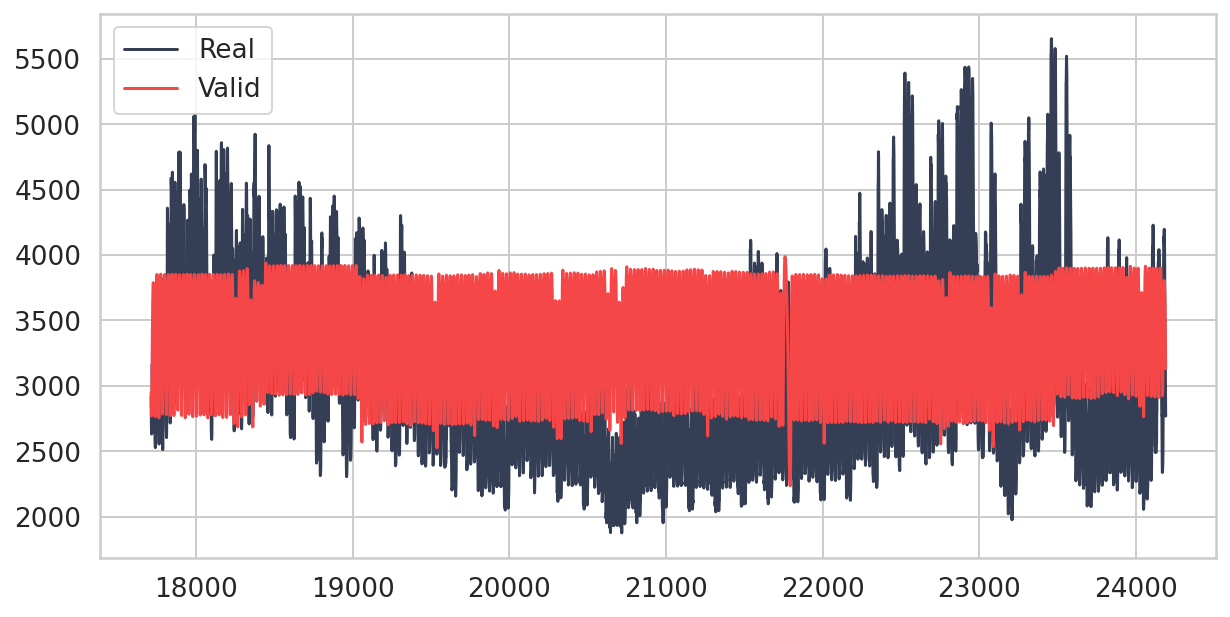

In [21]:
with torch.no_grad():
    
    preds = []
    for i in range(len(x_val)):
        test_seq = x_val[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()
        
y_all = df['ENE']
yscaler = scaler.fit(y_all.values.reshape(-1,1))

pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))
pred_values_ceiled  = list(pred_values.flatten())
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

score_table = pd.DataFrame({'DATE':save_test['DATE'],
                            'TIME':save_test['TIME'],
                            'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

old_max = max(score_table['Pred']-score_table['True'])
old_min = min(score_table['Pred']-score_table['True'])
new_max = 100
new_min = 0
old_range = (old_max - old_min)
new_range = (new_max - new_min)
scaled = 100-(round((((score_table['Pred']-score_table['True'] - old_min) * new_range) / old_range) + new_min))

# validation score
MAE = mean_absolute_error(score_table['True'], score_table['Pred'])
MAPE = MAE*100
score = round(sum(scaled.values)/len(scaled.values), 3)
print("MAE : {0}, MAPE : {1}, SCORE : {2}".format(MAE, MAPE, score))

#=========#

scailing_x = int(y_train.__len__()/2)

plt.figure(figsize=(10,5))
#plt.plot(range(scailing_x), yscaler.inverse_transform(y_train)[scailing_x+1:, [-1]])
plt.plot(range(scailing_x, scailing_x + y_test.__len__()),true_values, label='Real')
plt.plot(range(scailing_x, scailing_x + y_test.__len__()),pred_values_ceiled, label='Valid')
plt.legend()

In [22]:
tmp_dict = {} # 0 True 1 Pred
test_date = ['2021-01-01', '2021-02-01', '2021-03-20', '2021-07-23', '2021-07-26']

for idx, rows in enumerate(score_table['DATE']):
    if rows in test_date:
        if rows in tmp_dict:
            tmp_dict[rows][0].append(score_table['True'].iloc[idx])
            tmp_dict[rows][1].append(score_table['Pred'].iloc[idx])
        else:
            tmp_dict[rows] = [[score_table['True'].iloc[idx]], [score_table['Pred'].iloc[idx]]]

for i, j in tmp_dict.items():
    tmp_dict[i][0] = sum(tmp_dict[i][0])/len(tmp_dict[i][0])
    tmp_dict[i][1] = sum(tmp_dict[i][1])/len(tmp_dict[i][1])

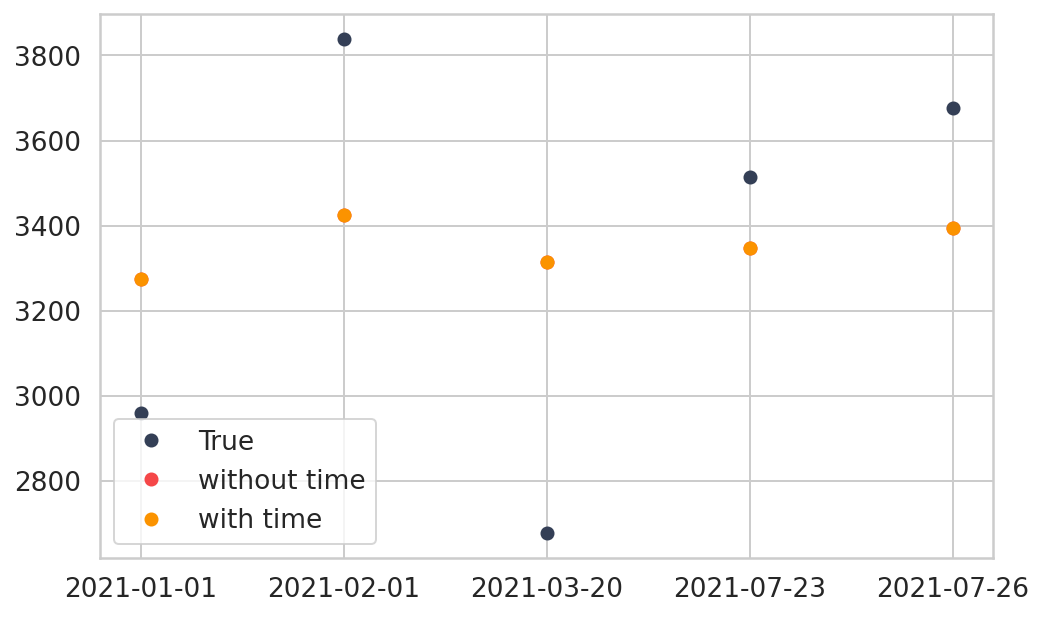

In [39]:
a = pd.DataFrame.from_dict(tmp_dict, orient = 'index')
b = a = pd.DataFrame.from_dict(tmp_dict1, orient = 'index')
plt.figure(figsize=(8,5))
plt.plot(a.index, a[0], 'o', label='True')
plt.plot(b.index, b[1], 'o', label='without time')
plt.plot(a.index, a[1], 'o', label='with time')
plt.legend()
plt.show()

In [24]:
tmp_dict = {} # 0 True 1 Pred
test_date = ['2021-01-01', '2021-02-01', '2021-03-20', '2021-07-23', '2021-07-26']

for idx, rows in enumerate(score_table['DATE']):
    if rows in test_date:
        if rows in tmp_dict:
            tmp_dict[rows][0].append(score_table['True'].iloc[idx])
            tmp_dict[rows][1].append(score_table['Pred'].iloc[idx])
        else:
            tmp_dict[rows] = [[score_table['True'].iloc[idx]], [score_table['Pred'].iloc[idx]]]

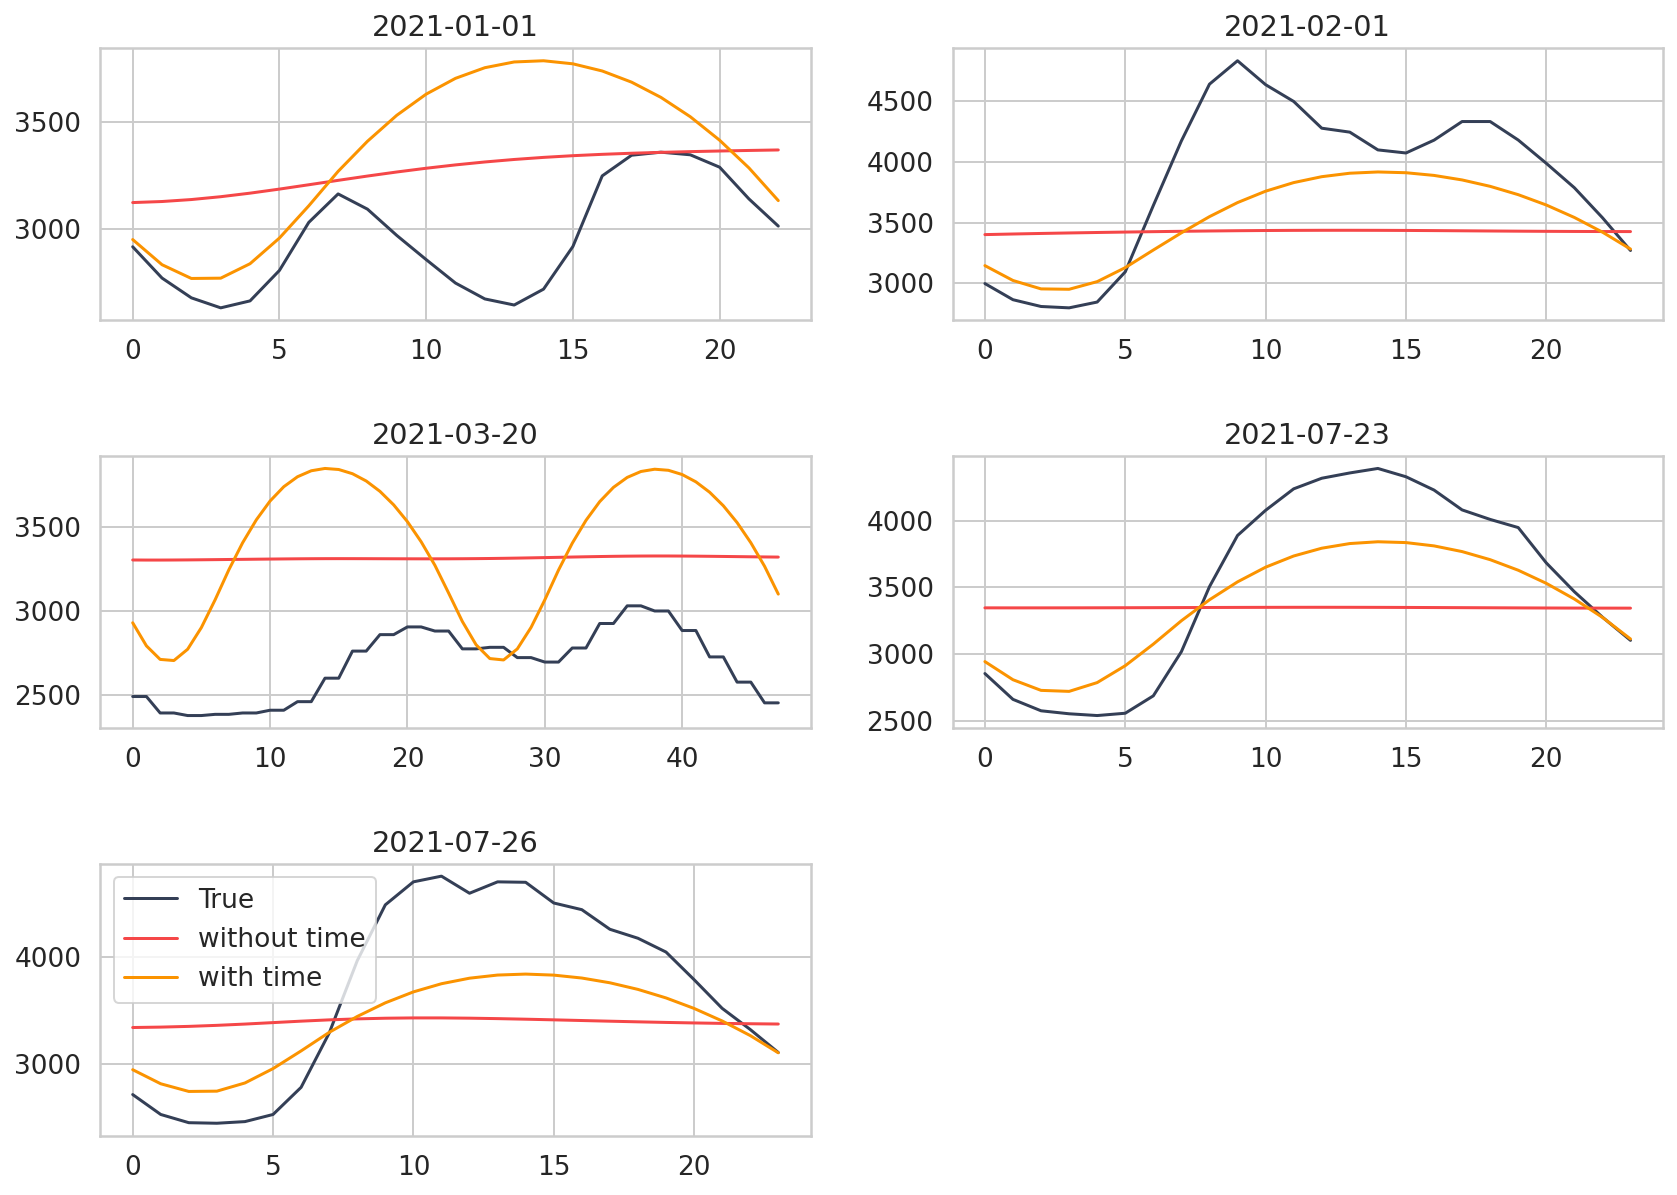

In [33]:
plt.subplots_adjust(hspace = 0.5)

plt.subplot(321).set_title('2021-01-01')
plt.plot([x for x in range(len(tmp_dict['2021-01-01'][0]))], tmp_dict['2021-01-01'][0], label='True')
plt.plot([x for x in range(len(tmp_dict1['2021-01-01'][0]))], tmp_dict1['2021-01-01'][1], label='without time')
plt.plot([x for x in range(len(tmp_dict['2021-01-01'][0]))], tmp_dict['2021-01-01'][1], label='with time')

plt.subplot(322).set_title('2021-02-01')
plt.plot([x for x in range(len(tmp_dict['2021-02-01'][0]))], tmp_dict['2021-02-01'][0], label='True')
plt.plot([x for x in range(len(tmp_dict1['2021-02-01'][0]))], tmp_dict1['2021-02-01'][1], label='without time')
plt.plot([x for x in range(len(tmp_dict['2021-02-01'][0]))], tmp_dict['2021-02-01'][1], label='with time')

plt.subplot(323).set_title('2021-03-20')
plt.plot([x for x in range(len(tmp_dict['2021-03-20'][0]))], tmp_dict['2021-03-20'][0], label='True')
plt.plot([x for x in range(len(tmp_dict1['2021-03-20'][0]))], tmp_dict1['2021-03-20'][1], label='without time')
plt.plot([x for x in range(len(tmp_dict['2021-03-20'][0]))], tmp_dict['2021-03-20'][1], label='with time')

plt.subplot(324).set_title('2021-07-23')
plt.plot([x for x in range(len(tmp_dict['2021-07-23'][0]))], tmp_dict['2021-07-23'][0], label='True')
plt.plot([x for x in range(len(tmp_dict1['2021-07-23'][0]))], tmp_dict1['2021-07-23'][1], label='without time')
plt.plot([x for x in range(len(tmp_dict['2021-07-23'][0]))], tmp_dict['2021-07-23'][1], label='with time')

plt.subplot(325).set_title('2021-07-26')
plt.plot([x for x in range(len(tmp_dict['2021-07-26'][0]))], tmp_dict['2021-07-26'][0], label='True')
plt.plot([x for x in range(len(tmp_dict1['2021-07-26'][0]))], tmp_dict1['2021-07-26'][1], label='without time')
plt.plot([x for x in range(len(tmp_dict['2021-07-26'][0]))], tmp_dict['2021-07-26'][1], label='with time')

plt.legend()
plt.show()

In [ ]:
# Results without time
tmp_dict1 = {'2021-01-01': [[2918.1989574432373,
   2771.6372060775757,
   2679.0183086395264,
   2632.200011253357,
   2664.7692518234253,
   2807.259819984436,
   3032.191411972046,
   3165.5218601226807,
   3094.2765197753906,
   2971.123945236206,
   2858.149356842041,
   2748.2280292510986,
   2673.9293718338013,
   2645.431258201599,
   2719.7299156188965,
   2919.2167110443115,
   3249.9983348846436,
   3346.6884155273438,
   3360.93741607666,
   3348.7240352630615,
   3290.7099418640137,
   3142.112627029419,
   3014.888925552368],
  [3125.0681800842285,
   3129.9863471984863,
   3139.2161254882812,
   3152.508590698242,
   3169.136100769043,
   3188.1274909973145,
   3208.426746368408,
   3229.063377380371,
   3249.2073364257812,
   3268.2358627319336,
   3285.723804473877,
   3301.401081085205,
   3315.118923187256,
   3326.8248901367188,
   3336.575698852539,
   3344.517868041992,
   3350.890869140625,
   3355.995391845703,
   3360.119297027588,
   3363.535816192627,
   3366.4621391296387,
   3369.049285888672,
   3371.3911094665527]],
 '2021-02-01': [[2996.568685531616,
   2863.2382373809814,
   2807.259819984436,
   2796.064136505127,
   2843.9002437591553,
   3093.2587661743164,
   3640.829671859741,
   4174.15157699585,
   4642.334663391113,
   4835.714824676514,
   4638.263648986816,
   4499.844207763672,
   4278.983798980713,
   4246.4145584106445,
   4099.852863311768,
   4074.4081230163574,
   4180.258323669434,
   4333.944519042969,
   4333.944519042969,
   4181.276077270508,
   3988.9136695861816,
   3787.3914794921875,
   3540.068464279175,
   3269.336441040039],
  [3400.6736946105957,
   3405.603115081787,
   3410.1361923217773,
   3414.282829284668,
   3418.095016479492,
   3421.6265449523926,
   3424.9141006469727,
   3427.913345336914,
   3430.5653114318848,
   3432.770519256592,
   3434.4600982666016,
   3435.6194190979004,
   3436.2379035949707,
   3436.3394088745117,
   3435.9212341308594,
   3435.0061111450195,
   3433.6876678466797,
   3432.1212005615234,
   3430.494415283203,
   3428.9797134399414,
   3427.6961555480957,
   3426.702033996582,
   3426.0061264038086,
   3425.5836753845215]],
 '2021-03-20': [[2491.7450065612793,
   2491.7450065612793,
   2394.037172317505,
   2394.037172317505,
   2378.7703619003296,
   2378.7703619003296,
   2385.894862174988,
   2385.894862174988,
   2394.037172317505,
   2394.037172317505,
   2410.3218488693237,
   2410.3218488693237,
   2461.211329460144,
   2461.211329460144,
   2600.648524284363,
   2600.648524284363,
   2761.459276199341,
   2761.459276199341,
   2859.1671104431152,
   2859.1671104431152,
   2904.967710494995,
   2904.967710494995,
   2880.540723800659,
   2880.540723800659,
   2774.6905794143677,
   2774.6905794143677,
   2783.8506994247437,
   2783.8506994247437,
   2722.7832889556885,
   2722.7832889556885,
   2696.3207387924194,
   2696.3207387924194,
   2779.779516220093,
   2779.779516220093,
   2925.3234577178955,
   2925.3234577178955,
   3030.155792236328,
   3030.155792236328,
   2999.622058868408,
   2999.622058868408,
   2883.594097137451,
   2883.594097137451,
   2726.8544721603394,
   2726.8544721603394,
   2577.2393474578857,
   2577.2393474578857,
   2454.086772918701,
   2454.086772918701],
  [3302.42378616333,
   3301.9912071228027,
   3301.9900817871094,
   3302.328582763672,
   3302.914207458496,
   3303.6616554260254,
   3304.498680114746,
   3305.3687896728516,
   3306.229221343994,
   3307.0878524780273,
   3307.925552368164,
   3308.7168884277344,
   3309.4206733703613,
   3309.9684867858887,
   3310.3067626953125,
   3310.4145698547363,
   3310.3375968933105,
   3310.1435890197754,
   3309.8957901000977,
   3309.642589569092,
   3309.4328269958496,
   3309.3013877868652,
   3309.300037384033,
   3309.464786529541,
   3309.8417739868164,
   3310.4528312683105,
   3311.288055419922,
   3312.347671508789,
   3313.617500305176,
   3315.062431335449,
   3316.6322746276855,
   3318.2709884643555,
   3319.9227561950684,
   3321.5031776428223,
   3322.937755584717,
   3324.1781005859375,
   3325.1679458618164,
   3325.837745666504,
   3326.149013519287,
   3326.10445022583,
   3325.742317199707,
   3325.122932434082,
   3324.3153915405273,
   3323.387439727783,
   3322.3996200561523,
   3321.400547027588,
   3320.4644927978516,
   3319.653350830078]],
 '2021-07-23': [[2855.095983505249,
   2661.7158784866333,
   2576.221537590027,
   2553.8301706314087,
   2540.5989236831665,
   2557.9013538360596,
   2688.1784286499023,
   3018.9600524902344,
   3505.4636039733887,
   3889.170440673828,
   4077.46138381958,
   4238.272304534912,
   4317.659786224365,
   4357.353527069092,
   4390.940746307373,
   4328.855525970459,
   4229.112071990967,
   4080.5148696899414,
   4009.2696418762207,
   3948.202175140381,
   3683.5767860412598,
   3467.8053703308105,
   3277.4786949157715,
   3103.4366397857666],
  [3347.06697845459,
   3346.9017791748047,
   3346.935314178467,
   3347.1590309143066,
   3347.518238067627,
   3347.9841270446777,
   3348.534641265869,
   3349.149974822998,
   3349.772735595703,
   3350.3459815979004,
   3350.810745239258,
   3351.128765106201,
   3351.251651763916,
   3351.1170616149902,
   3350.726119995117,
   3350.12068939209,
   3349.359287261963,
   3348.503807067871,
   3347.6089401245117,
   3346.7539100646973,
   3346.0060119628906,
   3345.42488861084,
   3345.043399810791,
   3344.8653717041016]],
 '2021-07-26': [[2717.6943521499634,
   2532.4566135406494,
   2456.122392654419,
   2451.033399581909,
   2466.300266265869,
   2532.4566135406494,
   2784.868453025818,
   3288.6744346618652,
   3961.433422088623,
   4480.506214141846,
   4694.2421226501465,
   4747.167110443115,
   4588.39192199707,
   4694.2421226501465,
   4690.170883178711,
   4497.808700561523,
   4435.723480224609,
   4253.539058685303,
   4170.080337524414,
   4041.838882446289,
   3785.3557472229004,
   3518.694850921631,
   3322.261428833008,
   3108.5256328582764],
  [3340.59854888916,
   3344.4210891723633,
   3351.1519470214844,
   3360.728328704834,
   3372.655086517334,
   3386.201202392578,
   3399.7466430664062,
   3411.6909561157227,
   3420.927936553955,
   3426.966037750244,
   3429.798957824707,
   3429.761371612549,
   3427.3781356811523,
   3423.2400512695312,
   3417.916763305664,
   3411.908145904541,
   3405.620895385742,
   3399.365379333496,
   3393.3968238830566,
   3387.930393218994,
   3383.104503631592,
   3378.979923248291,
   3375.6214714050293,
   3373.0489540100098]]}

In [34]:
for i, j in tmp_dict1.items():
    tmp_dict1[i][0] = sum(tmp_dict1[i][0])/len(tmp_dict1[i][0])
    tmp_dict1[i][1] = sum(tmp_dict1[i][1])/len(tmp_dict1[i][1])